In [1]:
# DeepFake Detection Model using EfficientNetB0
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configuration
IMAGE_SIZE = (240, 240)
BATCH_SIZE = 24
EPOCHS = 30 
RANDOM_SEED = 42
THRESHOLD = 0.5
MODEL_PATH = 'deepfake_model.keras'
INFERENCE_MODEL_PATH = 'deepfake_inference_model.keras'
LEARNING_RATE = 0.0005

In [3]:
# Set seeds for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:

def load_and_prepare_data():
    """Load metadata and prepare balanced dataset."""
    meta = pd.read_csv('finaldata.csv')
    
    # Create balanced dataset
    real_df = meta[meta['label'] == 'REAL']
    fake_df = meta[meta['label'] == 'FAKE']
    # Get counts
    real_count = len(real_df)

    real_df = real_df.sample(real_count, random_state=RANDOM_SEED)
    fake_df = fake_df.sample(real_count, random_state=RANDOM_SEED)

    print(f"Number of REAL entries: {len(real_df)}")
    print(f"Number of FAKE entries: {len(fake_df)}")
    # Combine datasets
    sample_meta = pd.concat([real_df, fake_df])
    print(f"Number of entries in combined dataset: {len(sample_meta)}")
    
    # Split into train/validation/test sets
    train_set, test_set = train_test_split(sample_meta, test_size=0.3, random_state=RANDOM_SEED)
    train_set, val_set = train_test_split(train_set, test_size=0.3, random_state=RANDOM_SEED)
    
    return train_set, val_set, test_set

In [5]:
def retrieve_dataset(df):
    """Extract image paths and labels from dataframe."""
    paths, labels = [], []
    for _, row in df.iterrows():
        img_path = row['path']
        if os.path.exists(img_path):
            paths.append(img_path)
            labels.append(1 if row['label'] == 'FAKE' else 0)
    return paths, np.array(labels)

def preprocess_image(path, label=None):
    """Preprocess a single image for the model."""
    # For TF Dataset
    if label is not None:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = tf.cast(img, tf.float32)
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        return img, label
    
    # For external image prediction
    else:
        img = cv2.imread(path)
        img = cv2.resize(img, IMAGE_SIZE)
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        return img

In [6]:
def create_tf_datasets(train_paths, train_labels, val_paths, val_labels, test_paths, test_labels):
    """Create TensorFlow datasets for training, validation and testing."""
    # Training dataset with augmentation
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000, seed=RANDOM_SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    # Validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    # Test dataset
    test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

In [7]:
def create_inference_model(base_model):
    """Create a separate model for inference without augmentation."""
    inputs = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

In [8]:

def plot_training_history(history):
    """Plot training and validation loss/accuracy."""
    plt.figure(figsize=(12, 4))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

In [9]:
def evaluate_model(model, test_dataset):
    """Evaluate model on test dataset."""
    y_pred = []
    y_true = []
    
    print("\nEvaluating model on test set...")
    for images, labels in test_dataset:
        batch_predictions = model.predict(images, verbose=0)
        batch_predictions = (batch_predictions > THRESHOLD).astype(int).flatten()
        y_pred.extend(batch_predictions)
        y_true.extend(labels.numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Display metrics
    print("\nTest Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return accuracy, precision, recall, conf_matrix



In [10]:
def visualize_predictions(model, test_df, num_samples=25):
    """Visualize model predictions on sample images."""
    # Get sample images
    sample_indices = np.random.choice(test_df.index, size=min(num_samples, len(test_df)), replace=False)
    sample_paths = [(test_df.loc[i, 'path'], test_df.loc[i, 'label']) for i in sample_indices]
    
    # Set up plot grid
    grid_size = int(np.ceil(np.sqrt(len(sample_paths))))
    plt.figure(figsize=(15, 15))
    
    for idx, (image_path, true_label) in enumerate(sample_paths):
        if os.path.exists(image_path):
            # Process image
            processed_image = preprocess_image(image_path)
            processed_image = np.expand_dims(processed_image, axis=0)
            prediction = model.predict(processed_image, verbose=0)
            
            # Determine predicted class
            predicted_class = "FAKE" if prediction[0, 0] > THRESHOLD else "REAL"
            correct = predicted_class == true_label
            
            # Plot image with prediction
            plt.subplot(grid_size, grid_size, idx+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            
            # Read and display image
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            
            # Add prediction label with color coding (green for correct, red for wrong)
            color = 'green' if correct else 'red'
            plt.xlabel(f'{predicted_class} ({prediction[0, 0]:.2f})', color=color)
    
    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()

In [ ]:
def build_model():
    """Build DeepFake detection model using EfficientNetB0."""
    # Clear previous TF session
    tf.keras.backend.clear_session()
    
    # Base model - EfficientNetB0 pretrained on ImageNet
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
    
    for layer in base_model.layers[:-15]:
        layer.trainable = False
    for layer in base_model.layers[-15:]:
        layer.trainable = True
    
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.15),
        tf.keras.layers.RandomZoom(0.15),
        tf.keras.layers.RandomContrast(0.15),
    ])
    
    # Simplified model architecture with some improvements
    inputs = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)
    
    # Compile model with simple but effective optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    return model, base_model

In [12]:
def main():
    """Main execution function."""
    # Load and prepare data
    print("Loading data...")
    train_df, val_df, test_df = load_and_prepare_data()
    
    # Get paths and labels
    print("\nProcessing training set...")
    train_paths, train_labels = retrieve_dataset(train_df)
    
    print("Processing validation set...")
    val_paths, val_labels = retrieve_dataset(val_df)
    
    print("Processing test set...")
    test_paths, test_labels = retrieve_dataset(test_df)

    print(f"Number of training samples: {len(train_df)}")
    print(f"Number of validation samples: {len(val_df)}")
    print(f"Number of test samples: {len(test_df)}")
    
    # Create TensorFlow datasets
    train_ds, val_ds, test_ds = create_tf_datasets(
        train_paths, train_labels,
        val_paths, val_labels,
        test_paths, test_labels
    )
    
    # Build model
    model, base_model = build_model()
    
    # Simple but effective callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            verbose=1
        )
    ]
    
    # Train model
    print("Starting training...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks
    )
    
    # Save training model
    model.save(MODEL_PATH)
    print(f"Training model saved to {MODEL_PATH}")
    
    # Create and save inference model (with matching architecture)
    inference_model = create_inference_model(base_model)
    
    # Copy weights but skip augmentation layers
    for i, layer in enumerate(inference_model.layers):
        if i > 0:  # Skip input layer
            if i == 1:  # Base model weights
                layer.set_weights(model.layers[2].get_weights())
            else:  # Other layers
                layer.set_weights(model.layers[i+1].get_weights())
    
    inference_model.save(INFERENCE_MODEL_PATH)
    print(f"Inference model saved to {INFERENCE_MODEL_PATH}")
    
    # Plot training history
    plot_training_history(history)
    # Evaluate model
    accuracy, precision, recall, conf_matrix = evaluate_model(inference_model, test_ds)
    # Visualize sample predictions
    visualize_predictions(inference_model, test_df, num_samples=16)

Loading data...
Number of REAL entries: 90037
Number of FAKE entries: 90037
Number of entries in combined dataset: 180074

Processing training set...
Processing validation set...
Processing test set...
Number of training samples: 88235
Number of validation samples: 37816
Number of test samples: 54023

Starting training...
Epoch 1/30
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 2459s 1s/step - accuracy: 0.7737 - loss: 0.4521 - val_accuracy: 0.8036 - val_loss: 0.3985 - learning_rate: 5.0000e-04
Epoch 2/30
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 2139s 1s/step - accuracy: 0.8243 - loss: 0.3626 - val_accuracy: 0.8004 - val_loss: 0.4022 - learning_rate: 5.0000e-04
Epoch 3/30
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 2038s 1s/step - accuracy: 0.8374 - loss: 0.3371 - val_accuracy: 0.8349 - val_loss: 0.3506 - learning_rate: 5.0000e-04
Epoch 4/30
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 2084s 1s/step - accuracy: 0.8536 - loss: 0.3144 - val_accuracy: 0.8635 - val_loss: 0.2874 - learning_rate: 5.0000e-04
Epoch 5/30
1736/1736 ━━━━━━━━━━━━━━━

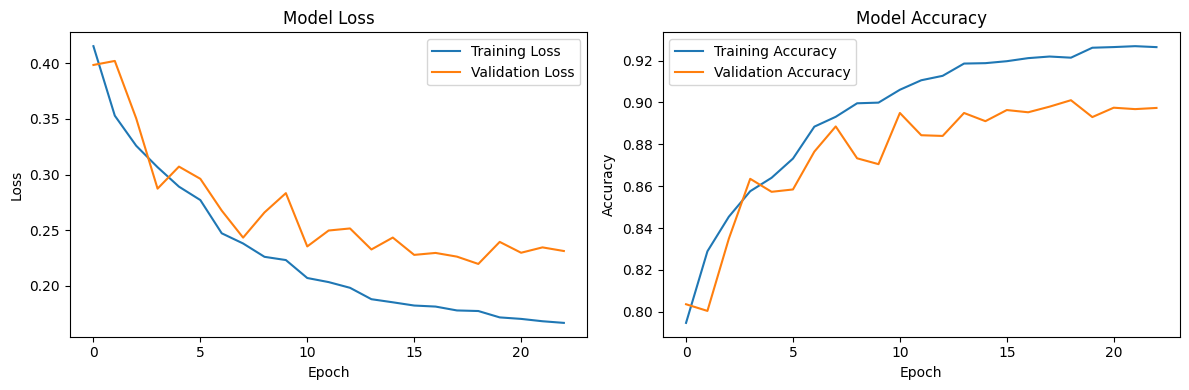


Evaluating model on test set...

Test Metrics:
Accuracy: 0.9029
Precision: 0.9425
Recall: 0.9300


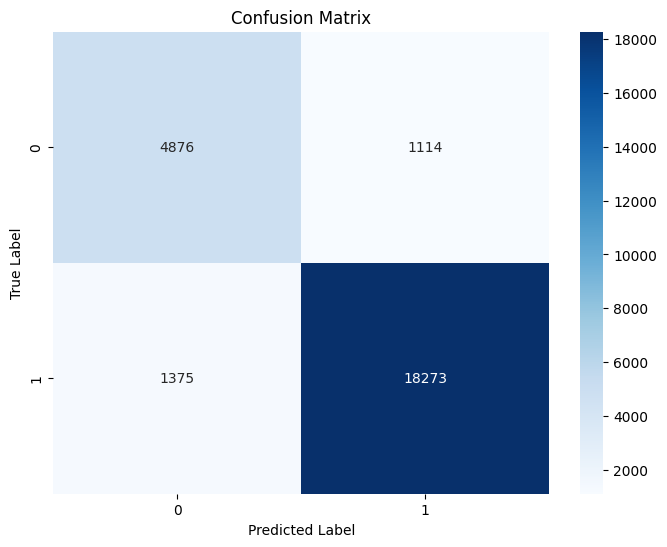

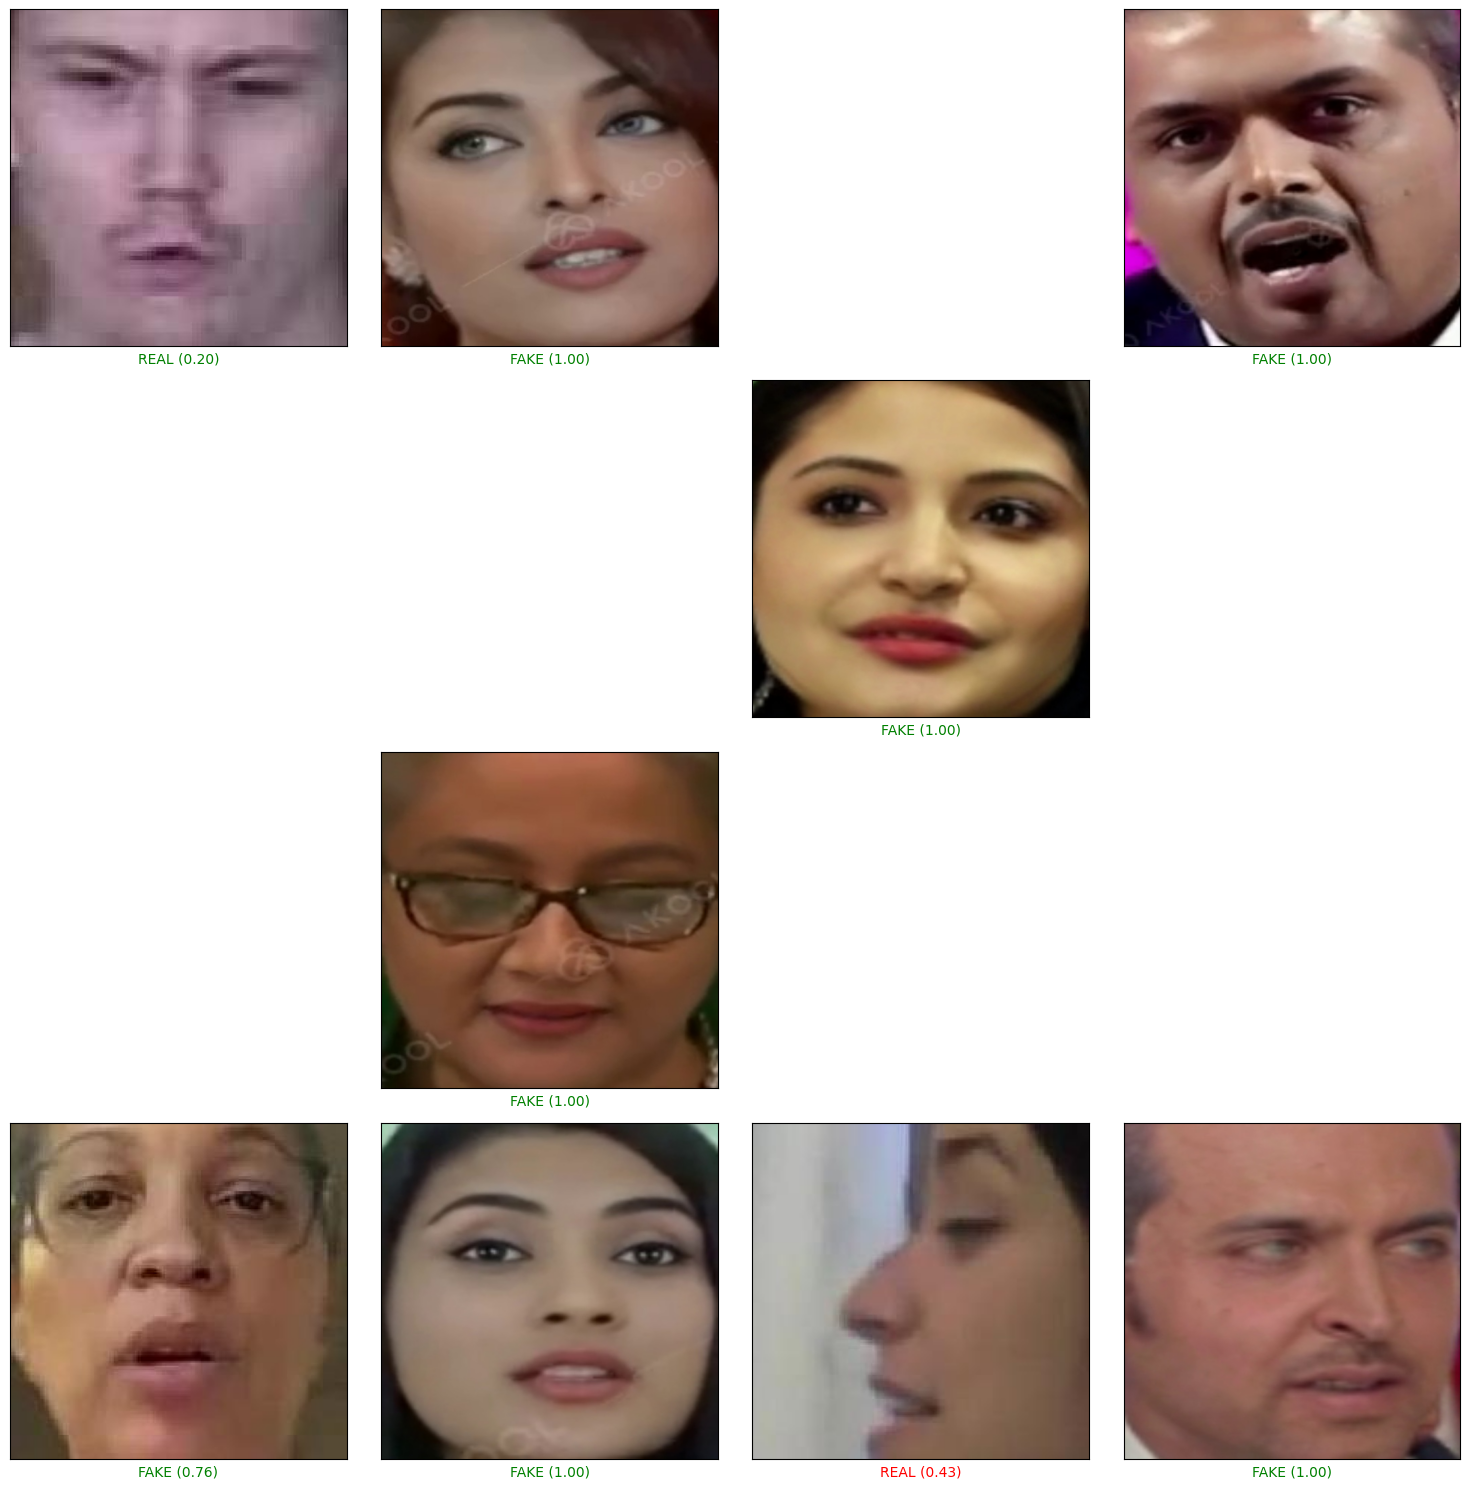

In [13]:
if __name__ == "__main__":
    main()